![tower_bridge](tower_bridge.jpeg)

As the climate changes, predicting the weather becomes ever more important for businesses. Since the weather depends on a lot of different factors, you will want to run a lot of experiments to determine what the best approach is to predict the weather. In this project, you will run experiments for different regression models predicting the mean temperature, using a combination of `sklearn` and `MLflow`.

You will be working with data stored in `london_weather.csv`, which contains the following columns:
- **date** - recorded date of measurement - (**int**)
- **cloud_cover** - cloud cover measurement in oktas - (**float**)
- **sunshine** - sunshine measurement in hours (hrs) - (**float**)
- **global_radiation** - irradiance measurement in Watt per square meter (W/m2) - (**float**)
- **max_temp** - maximum temperature recorded in degrees Celsius (°C) - (**float**)
- **mean_temp** - mean temperature in degrees Celsius (°C) - (**float**)
- **min_temp** - minimum temperature recorded in degrees Celsius (°C) - (**float**)
- **precipitation** - precipitation measurement in millimeters (mm) - (**float**)
- **pressure** - pressure measurement in Pascals (Pa) - (**float**)
- **snow_depth** - snow depth measurement in centimeters (cm) - (**float**)

In [1]:
# Imports
import pandas as pd
import numpy as np
import mlflow
import mlflow.sklearn
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, StandardScaler, Normalizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

# Read in the data
weather = pd.read_csv("london_weather.csv")

# Exploratory Data Analysis

In [2]:
#print(weather.value_counts())
columns = weather.columns
weather.isna().any()

date                False
cloud_cover          True
sunshine            False
global_radiation     True
max_temp             True
mean_temp            True
min_temp             True
precipitation        True
pressure             True
snow_depth           True
dtype: bool

In [3]:
weather.describe()

,date,cloud_cover,sunshine,global_radiation,max_temp,mean_temp,min_temp,precipitation,pressure,snow_depth
count,1.534100e+04,15322.000000,15341.000000,15322.000000,15335.000000,15305.000000,15339.000000,15335.000000,15337.000000,13900.000000
mean,1.999567e+07,5.268242,4.350238,118.756951,15.388777,11.475511,7.559867,1.668634,101536.605594,0.037986
std,1.212176e+05,2.070072,4.028339,88.898272,6.554754,5.729709,5.326756,3.738540,1049.722604,0.545633
min,1.979010e+07,0.000000,0.000000,8.000000,-6.200000,-7.600000,-11.800000,0.000000,95960.000000,0.000000
25%,1.989070e+07,4.000000,0.500000,41.000000,10.500000,7.000000,3.500000,0.000000,100920.000000,0.000000
50%,2.000010e+07,6.000000,3.500000,95.000000,15.000000,11.400000,7.800000,0.000000,101620.000000,0.000000
75%,2.010070e+07,7.000000,7.200000,186.000000,20.300000,16.000000,11.800000,1.600000,102240.000000,0.000000
max,2.020123e+07,9.000000,16.000000,402.000000,37.900000,29.000000,22.300000,61.800000,104820.000000,22.000000


In [4]:
weather["date"] = pd.to_datetime(weather["date"], format="%Y%m%d")
# Set date as index (crucial for time-series rolling operations)
weather = weather.set_index("date")
weather = weather.sort_index()
weather

,cloud_cover,sunshine,global_radiation,max_temp,mean_temp,min_temp,precipitation,pressure,snow_depth
date,,,,,,,,,
1979-01-01,2.0,7.0,52.0,2.3,-4.1,-7.5,0.4,101900.0,9.0
1979-01-02,6.0,1.7,27.0,1.6,-2.6,-7.5,0.0,102530.0,8.0
1979-01-03,5.0,0.0,13.0,1.3,-2.8,-7.2,0.0,102050.0,4.0
1979-01-04,8.0,0.0,13.0,-0.3,-2.6,-6.5,0.0,100840.0,2.0
1979-01-05,6.0,2.0,29.0,5.6,-0.8,-1.4,0.0,102250.0,1.0
...,...,...,...,...,...,...,...,...,...
2020-12-27,1.0,0.9,32.0,7.5,7.5,7.6,2.0,98000.0,NaN
2020-12-28,7.0,3.7,38.0,3.6,1.1,-1.3,0.2,97370.0,NaN
2020-12-29,7.0,0.0,21.0,4.1,2.6,1.1,0.0,98830.0,NaN


## Data Visualization

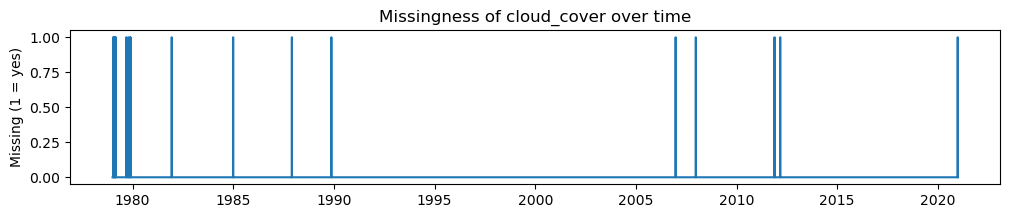

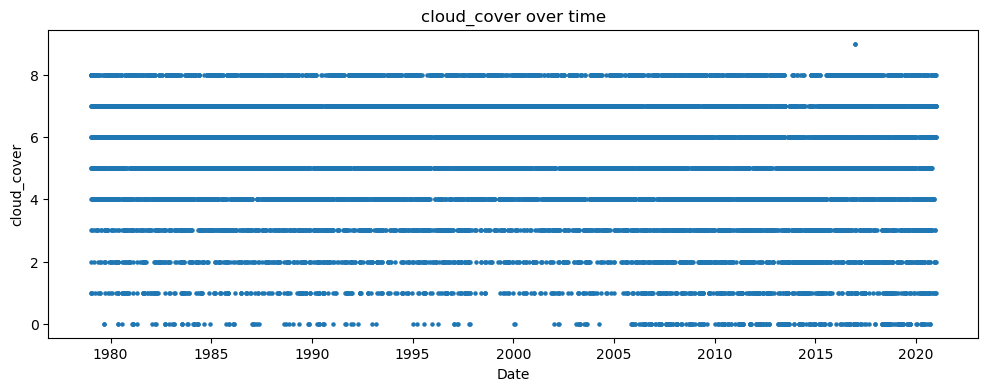

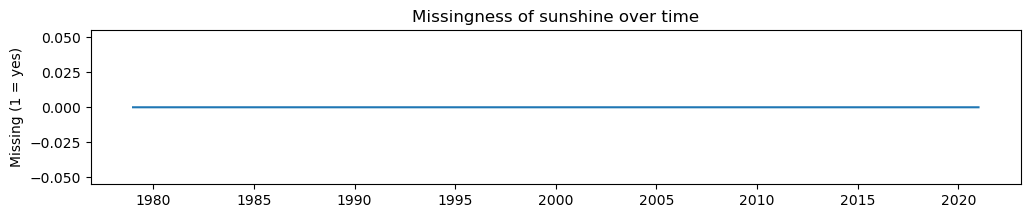

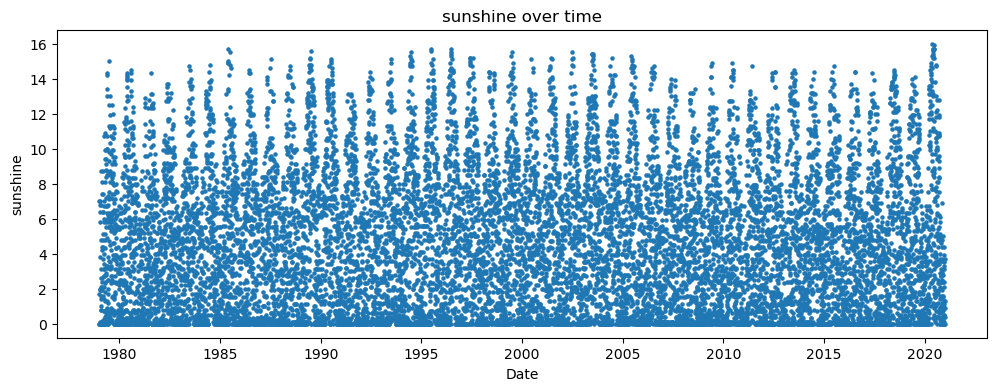

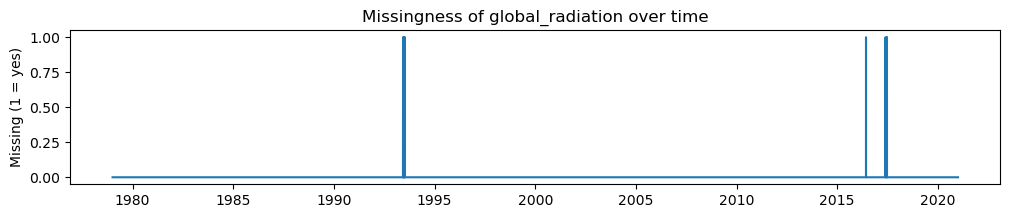

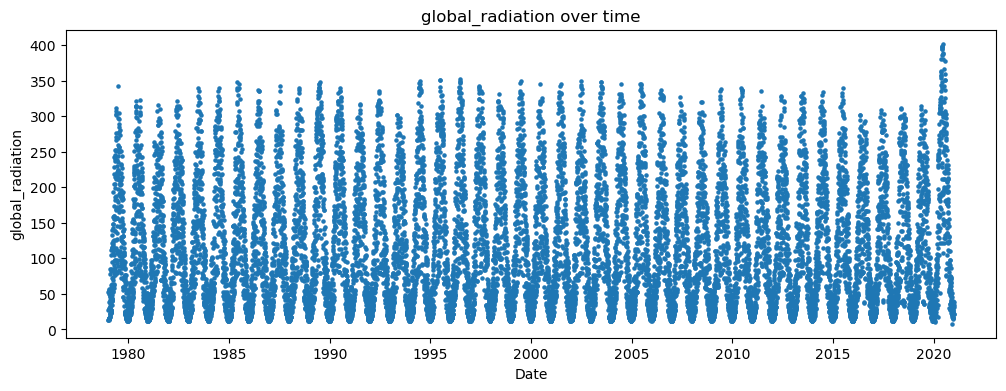

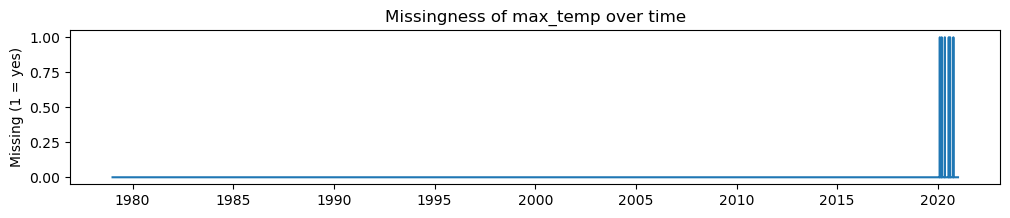

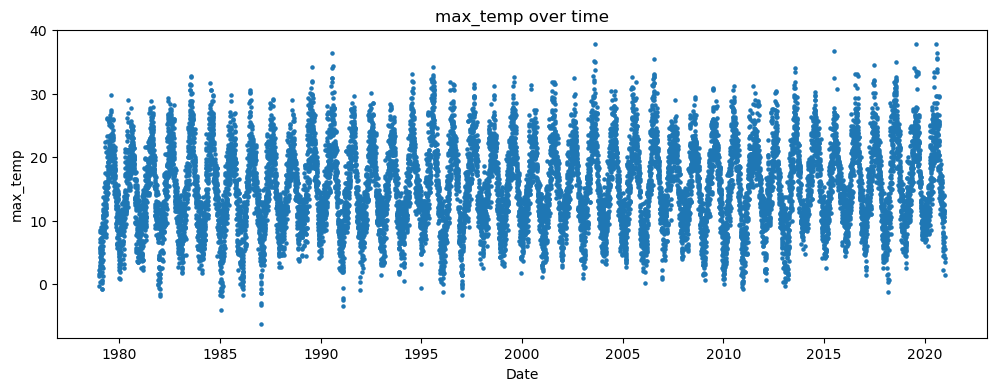

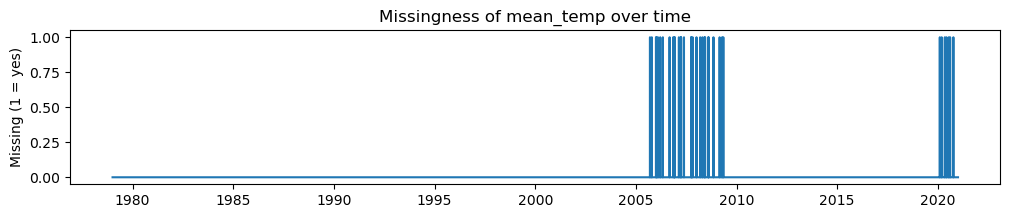

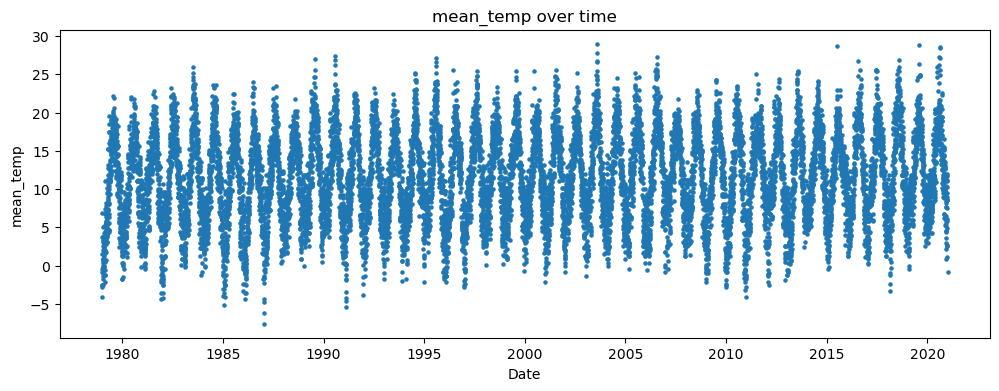

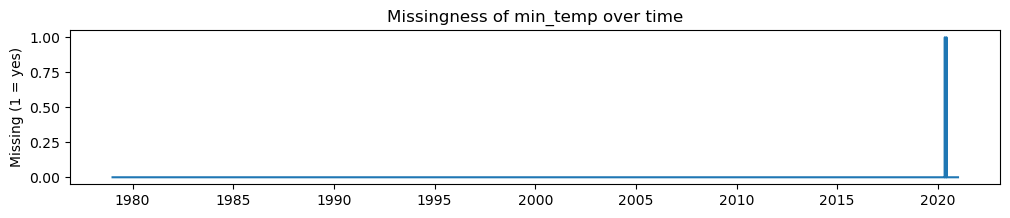

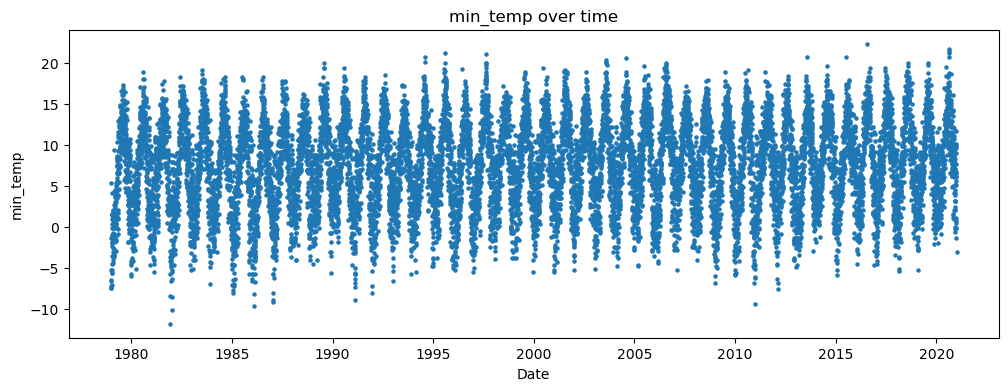

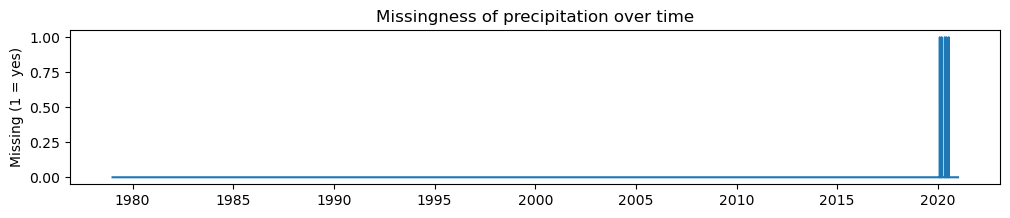

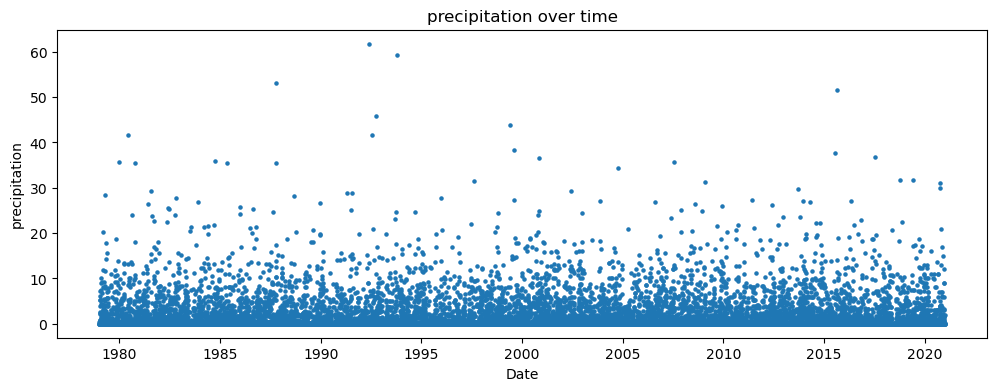

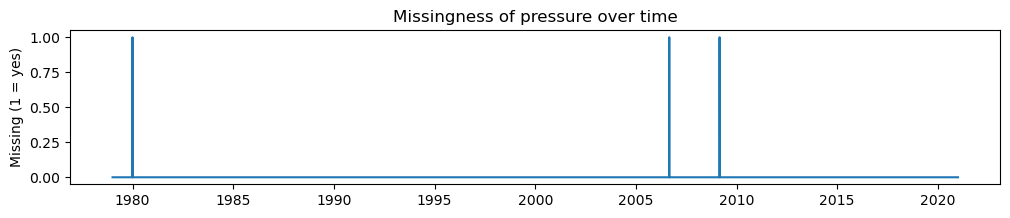

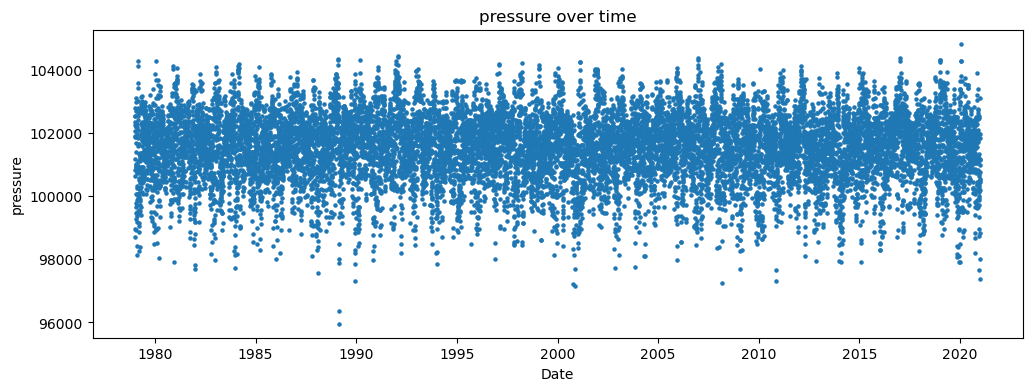

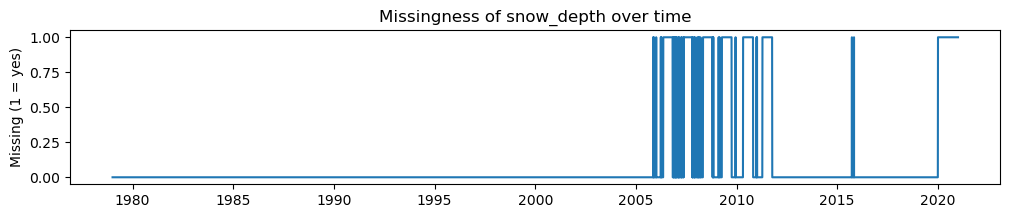

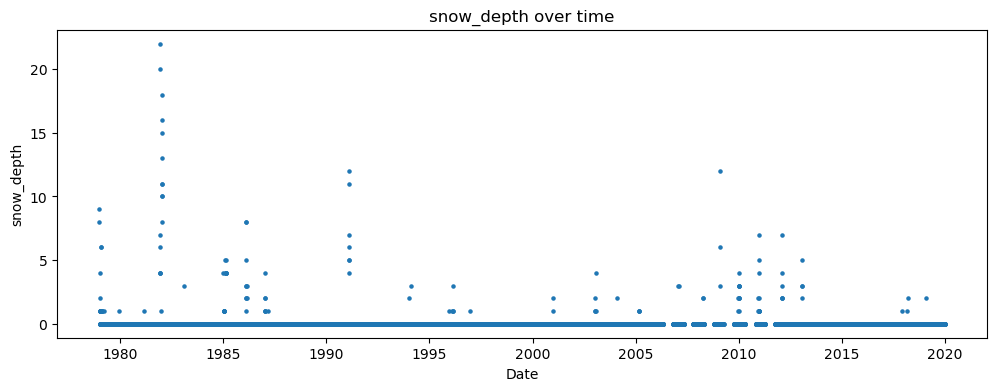

In [5]:
def col_against_time(column,df):
    plt.figure(figsize=(12, 4))
    plt.scatter(df.index, df[column], s=5)
    plt.title(f"{column} over time")
    plt.xlabel("Date")
    plt.ylabel(column)
    plt.show()


def missing_over_time(column,df):
    plt.figure(figsize=(12, 2))
    plt.plot(df.index, df[column].isna().astype(int))
    plt.title(f"Missingness of {column} over time")
    plt.ylabel("Missing (1 = yes)")
    plt.show()
def print_all_cols():
    for column in columns[1:]:
        missing_over_time(column,weather)
        col_against_time(column, weather)
print_all_cols()

## Handling missing values: Rolling Mean for short gaps and Seasonal Averaging for large gaps.

In [6]:
# Calculate rolling mean. 
WINDOW = 15
ROLL_COLS = ['cloud_cover', 'global_radiation', 'pressure']
for col in ROLL_COLS:
    # min_periods=1 ensures we get a value even if only 1 day in the window has data.
    # center=True looks at 7 days before and 7 days after.
    rolling_val = weather[col].rolling(window=WINDOW, min_periods=1, center=True).mean()
    
    # Fill only the missing values in the column with the calculated rolling values
    weather[col] = weather[col].fillna(rolling_val)

In [7]:
# Seasonal Mean (for long gaps)
SEASONAL_COLS = ['snow_depth', 'precipitation', 'mean_temp', 'min_temp', 'max_temp']
# Create temporary columns to group by
weather['day'] = weather.index.day
weather['month'] = weather.index.month
for col in SEASONAL_COLS:
    # 1. Group by Month and Day
    # 2. Calculate the mean for that specific day across all years
    # 3. Use 'transform' to map these means back to the original dataframe shape
    seasonal_mean = weather.groupby(['month', 'day'])[col].transform('mean')
    
    # Fill missing values
    weather[col] = weather[col].fillna(seasonal_mean)

# Remove the temporary helper columns
weather = weather.drop(columns=['day', 'month'])

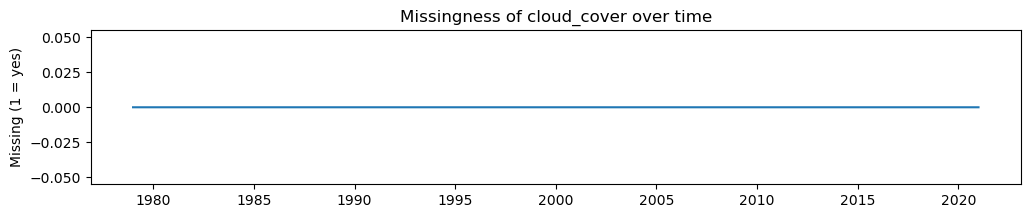

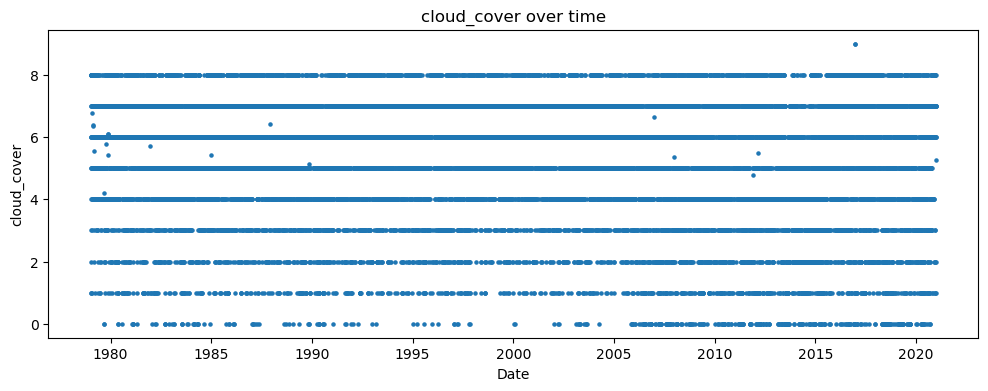

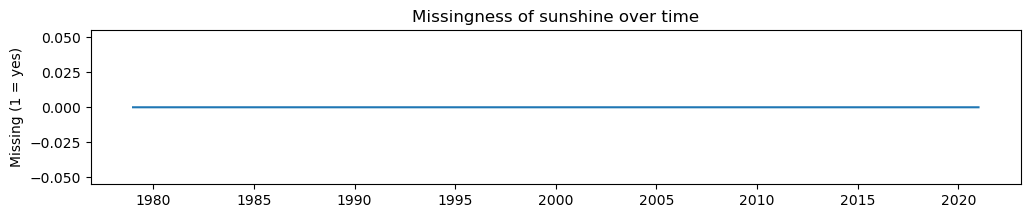

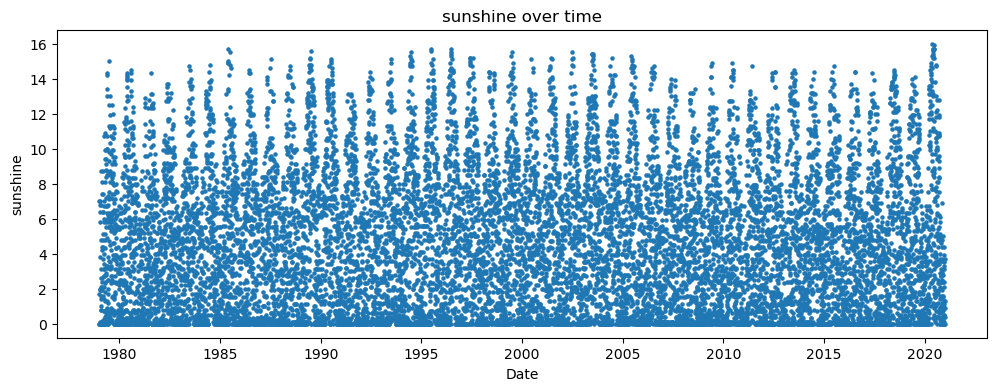

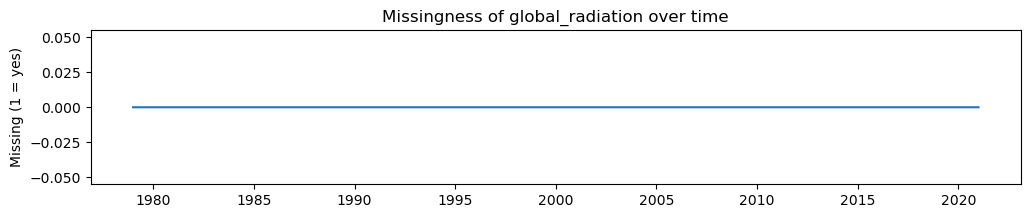

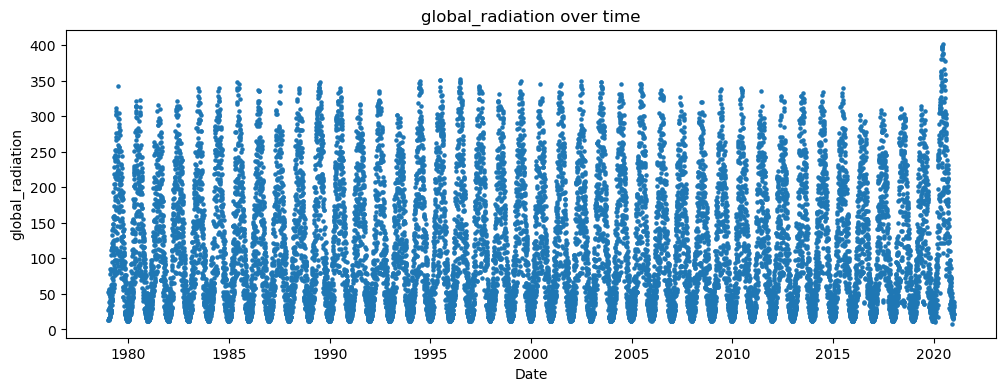

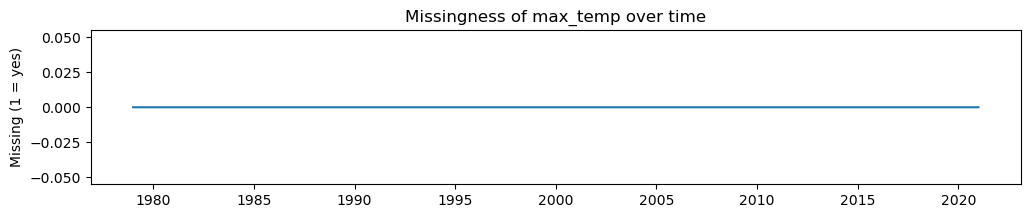

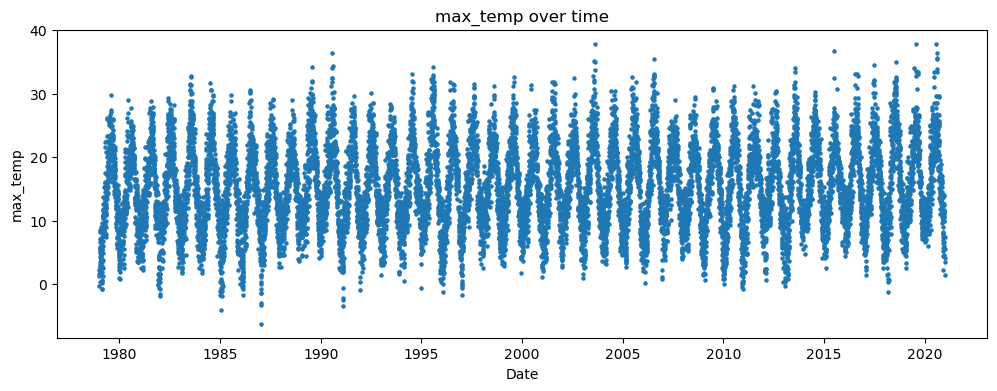

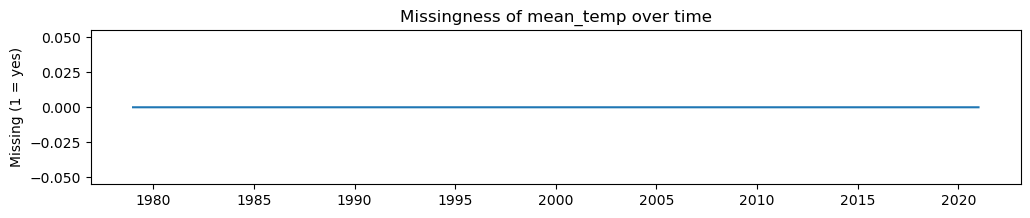

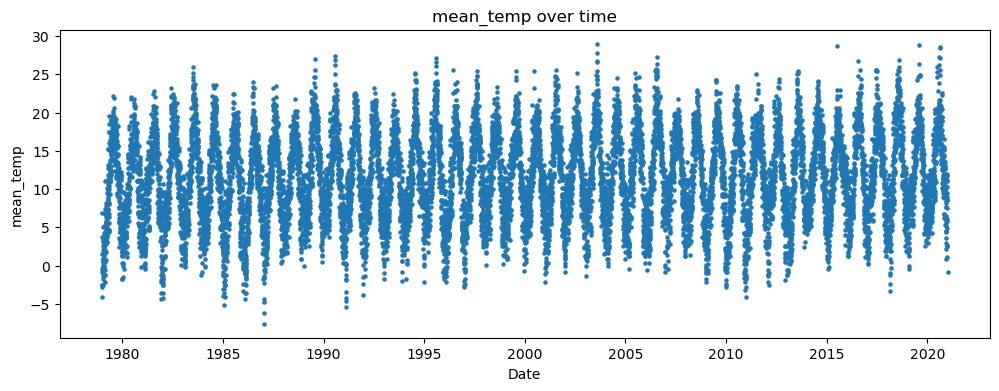

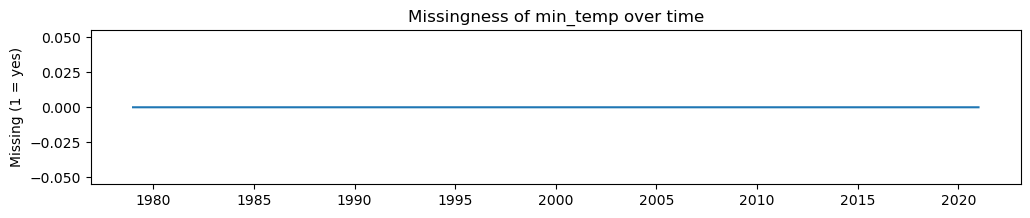

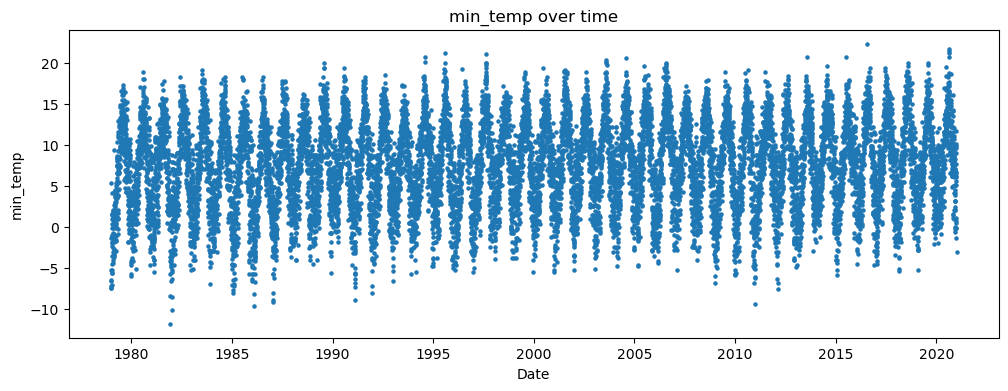

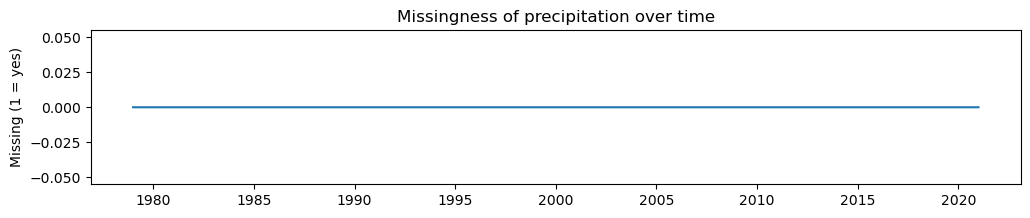

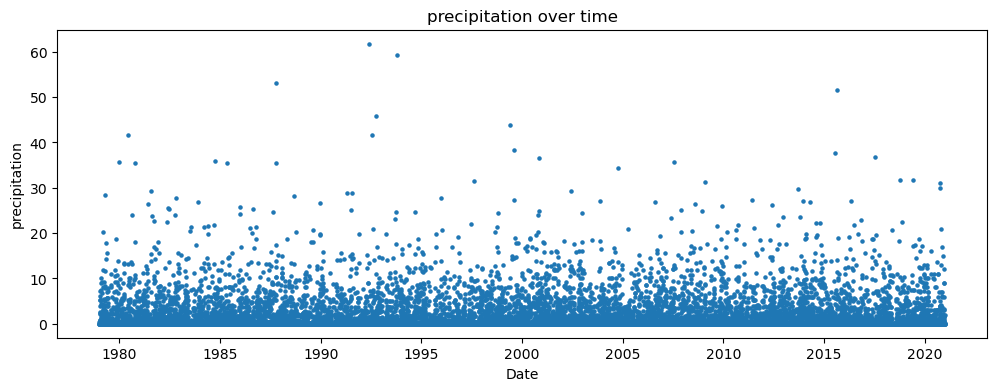

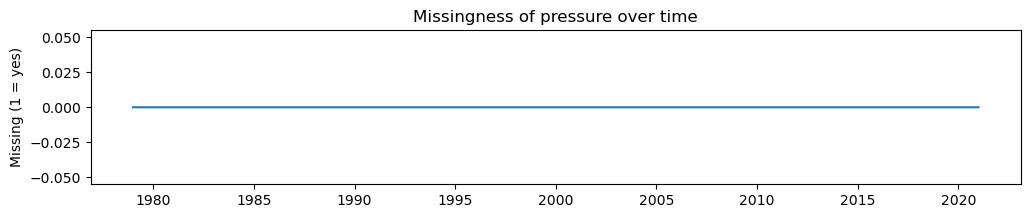

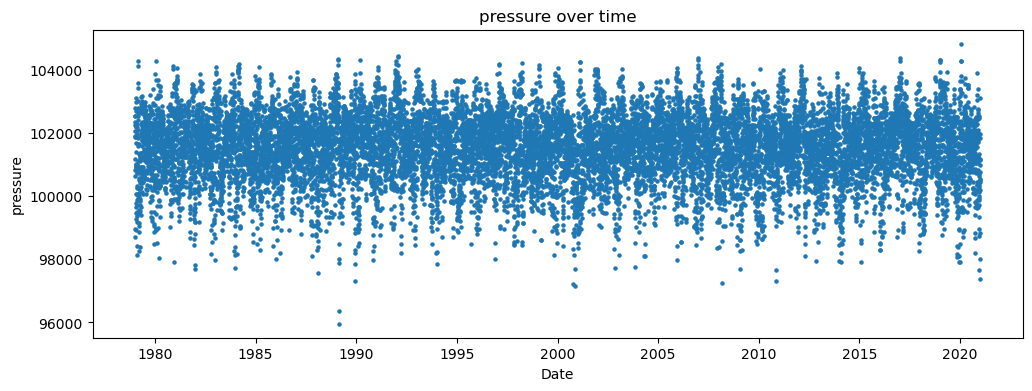

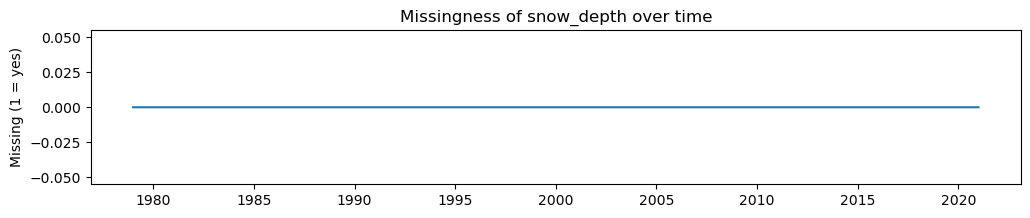

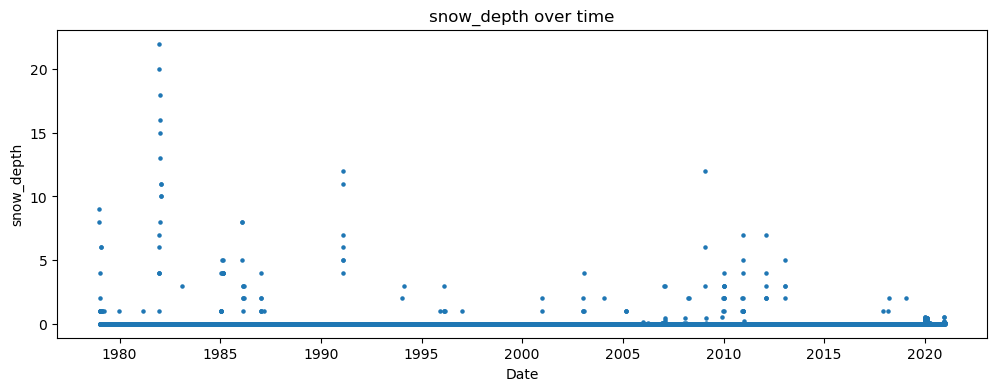

In [8]:
print_all_cols()

# ML Experiments

In [9]:
# Setup & Configuration
# ML Flow setup
mlflow.set_experiment("London-mean_temp-Prediction")
mlflow.sklearn.autolog(log_models=True, log_input_examples=True)
# Dataset praparation
SEED = 37
y,X = weather["mean_temp"], weather.drop(columns=["mean_temp"])
X_train, X_test, y_train, y_test = train_test_split(X,y, shuffle = False, random_state = SEED, test_size = 0.15)
# Model, parameter and misc config
models = {
    "LinearRegression" : LinearRegression(),
    "RandomForestRegressor" : RandomForestRegressor(),
    "DecisionTreeRegressor" : DecisionTreeRegressor()
}
# 4. Robust Parameter Grids (using numpy for ranges)
param_grids = {
    "LinearRegression": {
        "fit_intercept": [True, False]
    },
    "RandomForestRegressor": {
        "n_estimators": np.arange(50, 500, 50),      # [50, 100, ..., 450]
        "max_depth": np.arange(5, 30, 5),            # [5, 10, ..., 25]
        "min_samples_split": [2, 5, 10]
    },
    "DecisionTreeRegressor": {
        "max_depth": np.arange(3, 21, 3),            # [3, 6, ..., 18]
        "min_samples_split": np.arange(20, 100, 20)  # [20, 40, 60, 80]
    }
}
scalers = [MinMaxScaler(), Normalizer(), StandardScaler()]

print("✅ Configuration loaded.")
print(f"Data Shapes: Train {X_train.shape}, Test {X_test.shape}")

2025/12/15 16:50:06 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2025/12/15 16:50:06 INFO mlflow.store.db.utils: Updating database tables
2025/12/15 16:50:06 INFO alembic.runtime.migration: Context impl SQLiteImpl.
2025/12/15 16:50:06 INFO alembic.runtime.migration: Will assume non-transactional DDL.
2025/12/15 16:50:06 INFO alembic.runtime.migration: Context impl SQLiteImpl.
2025/12/15 16:50:06 INFO alembic.runtime.migration: Will assume non-transactional DDL.


✅ Configuration loaded.
Data Shapes: Train (13039, 8), Test (2302, 8)


## Experiment "Raw": baseline models

In [10]:
from sklearn.metrics import mean_squared_error, r2_score

def evaluate_and_log(model, X_test, y_test, prefix="test"):
    """
    Helper function to calculate and log metrics for the test set.
    """
    predictions = model.predict(X_test)
    mse = mean_squared_error(y_test, predictions)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, predictions)
    
    # Log custom metrics with a prefix (e.g., 'test_rmse')
    mlflow.log_metric(f"{prefix}_mse", mse)
    mlflow.log_metric(f"{prefix}_rmse", rmse)
    mlflow.log_metric(f"{prefix}_r2", r2)
    
    print(f"    > Test RMSE: {rmse:.4f} | R2: {r2:.4f}")

def run_experiment(model_name, models, param_grids, scalers, X_train, y_train, X_test, y_test):
    """
    Runs experiments and evaluates them on the test set.
    """
    print(f"\n🚀 Processing: {model_name}")
    model_instance = models[model_name]
    grid = param_grids[model_name]

    # Start Parent Run (The "Folder" for this model)
    with mlflow.start_run(run_name=model_name, tags={"model_class": model_name}) as parent_run:
        
        # 1. RAW RUN
        with mlflow.start_run(run_name="Raw", nested=True):
            model_instance.fit(X_train, y_train)
            evaluate_and_log(model_instance, X_test, y_test) # <--- Evaluation added
            print(f"  - Raw run completed")

        # 2. HYPERPARAMETER TUNED (Randomized Search)
        with mlflow.start_run(run_name="HyperParam_Tuned", nested=True):
            cv = KFold(n_splits=3, shuffle=False)
            search = RandomizedSearchCV(
                model_instance, grid, n_iter=10, cv=cv, random_state=SEED, n_jobs=-1
            )
            search.fit(X_train, y_train)
            
            # Log best params and evaluate best model on test set
            mlflow.log_params(search.best_params_)
            evaluate_and_log(search.best_estimator_, X_test, y_test) # <--- Evaluation added
            print(f"  - Tuned run completed (Val Score: {search.best_score_:.4f})")

        # 3. CROSS VALIDATION RUN (Grid Search)
        with mlflow.start_run(run_name="Cross_Validation", nested=True):
            cv = KFold(n_splits=3, shuffle=False)
            search = GridSearchCV(model_instance, grid, cv=cv, n_jobs=-1)
            search.fit(X_train, y_train)
            
            evaluate_and_log(search.best_estimator_, X_test, y_test) # <--- Evaluation added
            print(f"  - CV run completed (Val Score: {search.best_score_:.4f})")

        # 4. ROBUST PIPELINE RUNS
        for scaler in scalers:
            scaler_name = scaler.__class__.__name__
            
            with mlflow.start_run(run_name=f"Pipeline_{scaler_name}", nested=True):
                pipe = Pipeline([
                    ('scaler', scaler),
                    ('model', model_instance)
                ])
                
                pipeline_grid = {f"model__{k}": v for k, v in grid.items()}
                
                cv = KFold(n_splits=3, shuffle=False)
                search = RandomizedSearchCV(
                    pipe, 
                    pipeline_grid, 
                    n_iter=10, 
                    cv=cv, 
                    random_state=SEED, 
                    n_jobs=-1
                )
                
                search.fit(X_train, y_train)
                evaluate_and_log(search.best_estimator_, X_test, y_test) # <--- Evaluation added
                
                print(f"  - Pipeline ({scaler_name}) run completed")

In [11]:
# --- CELL 3: Execute All Experiments ---

print("Starting Experiment Loop...")

for model_name in models.keys():
    # Added X_test and y_test to arguments
    run_experiment(model_name, models, param_grids, scalers, X_train, y_train, X_test, y_test)

print("\n✅ All experiments finished. Check MLflow UI.")

Starting Experiment Loop...

🚀 Processing: LinearRegression


2025/12/15 16:50:29 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\garba\miniconda3\envs\torch-cuda\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html"


    > Test RMSE: 0.9252 | R2: 0.9728
  - Raw run completed


c:\Users\garba\miniconda3\envs\torch-cuda\Lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 2 is smaller than n_iter=10. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
2025/12/15 16:50:43 INFO mlflow.sklearn.utils: Logging the 5 best runs, no runs will be omitted.


    > Test RMSE: 0.9252 | R2: 0.9728
  - Tuned run completed (Val Score: 0.9754)


2025/12/15 16:50:58 INFO mlflow.sklearn.utils: Logging the 5 best runs, no runs will be omitted.


    > Test RMSE: 0.9252 | R2: 0.9728
  - CV run completed (Val Score: 0.9754)


c:\Users\garba\miniconda3\envs\torch-cuda\Lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 2 is smaller than n_iter=10. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
2025/12/15 16:51:12 INFO mlflow.sklearn.utils: Logging the 5 best runs, no runs will be omitted.


    > Test RMSE: 0.9252 | R2: 0.9728
  - Pipeline (MinMaxScaler) run completed


c:\Users\garba\miniconda3\envs\torch-cuda\Lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 2 is smaller than n_iter=10. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
2025/12/15 16:51:27 INFO mlflow.sklearn.utils: Logging the 5 best runs, no runs will be omitted.


    > Test RMSE: 0.9277 | R2: 0.9726
  - Pipeline (Normalizer) run completed


c:\Users\garba\miniconda3\envs\torch-cuda\Lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 2 is smaller than n_iter=10. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
2025/12/15 16:51:40 INFO mlflow.sklearn.utils: Logging the 5 best runs, no runs will be omitted.


    > Test RMSE: 0.9252 | R2: 0.9728
  - Pipeline (StandardScaler) run completed

🚀 Processing: RandomForestRegressor


    > Test RMSE: 0.9412 | R2: 0.9718
  - Raw run completed


2025/12/15 16:52:40 INFO mlflow.sklearn.utils: Logging the 5 best runs, 5 runs will be omitted.


    > Test RMSE: 0.9290 | R2: 0.9725
  - Tuned run completed (Val Score: 0.9762)


2025/12/15 16:55:01 INFO mlflow.sklearn.utils: Logging the 5 best runs, 130 runs will be omitted.


    > Test RMSE: 0.9292 | R2: 0.9725
  - CV run completed (Val Score: 0.9763)


2025/12/15 16:55:29 INFO mlflow.sklearn.utils: Logging the 5 best runs, 5 runs will be omitted.


    > Test RMSE: 0.9312 | R2: 0.9724
  - Pipeline (MinMaxScaler) run completed


2025/12/15 16:56:04 INFO mlflow.sklearn.utils: Logging the 5 best runs, 5 runs will be omitted.


    > Test RMSE: 0.9304 | R2: 0.9725
  - Pipeline (Normalizer) run completed


2025/12/15 16:56:31 INFO mlflow.sklearn.utils: Logging the 5 best runs, 5 runs will be omitted.


    > Test RMSE: 0.9297 | R2: 0.9725
  - Pipeline (StandardScaler) run completed

🚀 Processing: DecisionTreeRegressor


    > Test RMSE: 1.3083 | R2: 0.9456
  - Raw run completed


2025/12/15 16:56:41 INFO mlflow.sklearn.utils: Logging the 5 best runs, 5 runs will be omitted.


    > Test RMSE: 1.0674 | R2: 0.9638
  - Tuned run completed (Val Score: 0.9680)


2025/12/15 16:56:47 INFO mlflow.sklearn.utils: Logging the 5 best runs, 19 runs will be omitted.


    > Test RMSE: 1.0674 | R2: 0.9638
  - CV run completed (Val Score: 0.9680)


2025/12/15 16:56:54 INFO mlflow.sklearn.utils: Logging the 5 best runs, 5 runs will be omitted.


    > Test RMSE: 1.0665 | R2: 0.9638
  - Pipeline (MinMaxScaler) run completed


2025/12/15 16:57:00 INFO mlflow.sklearn.utils: Logging the 5 best runs, 5 runs will be omitted.


    > Test RMSE: 1.0561 | R2: 0.9645
  - Pipeline (Normalizer) run completed


2025/12/15 16:57:07 INFO mlflow.sklearn.utils: Logging the 5 best runs, 5 runs will be omitted.


    > Test RMSE: 1.0669 | R2: 0.9638
  - Pipeline (StandardScaler) run completed

✅ All experiments finished. Check MLflow UI.


In [33]:
!mlflow ui

^C


In [13]:
# 1. Search all runs and store in the variable 'experiment_results'
experiment_results = mlflow.search_runs()

# 2. Filter for successful runs that have a Test RMSE logged
#    (This removes parent runs that might not have metrics)
df_viz = experiment_results[
    (experiment_results.status == "FINISHED") & 
    (experiment_results["metrics.test_rmse"].notna())
].copy()

# 3. Create a readable 'Model_ID' for the chart
#    This combines the Model Name (from tags) with the specific Run Name
def get_readable_name(row):
    # Use the parent model class if available, otherwise fallback
    model_class = row.get("tags.model_class", "")
    if not model_class and "tags.mlflow.parentRunId" in row:
        # If it's a child run, we might not have the class name directly in this row, 
        # so we stick to the run name or try to map it manually.
        # For simplicity here, we use the Run Name.
        pass
    return f"{row['tags.mlflow.runName']} ({row.run_id[:4]})"

df_viz["Model_ID"] = df_viz.apply(get_readable_name, axis=1)

# 4. Sort by RMSE (Lower is better) and pick top 15
df_viz = df_viz.sort_values("metrics.test_rmse", ascending=True).head(15)

# Display the top 5 rows
print(df_viz[["Model_ID", "metrics.test_rmse", "metrics.test_r2"]].to_string(index=False))

                      Model_ID  metrics.test_rmse  metrics.test_r2
                    Raw (b9ca)           0.925229         0.972771
       Cross_Validation (135c)           0.925229         0.972771
Pipeline_StandardScaler (028a)           0.925229         0.972771
       HyperParam_Tuned (80b6)           0.925229         0.972771
  Pipeline_MinMaxScaler (adb7)           0.925229         0.972771
    Pipeline_Normalizer (540f)           0.927683         0.972626
       HyperParam_Tuned (176e)           0.928975         0.972550
       Cross_Validation (8891)           0.929158         0.972539
Pipeline_StandardScaler (8f52)           0.929651         0.972510
    Pipeline_Normalizer (78ee)           0.930389         0.972466
  Pipeline_MinMaxScaler (4115)           0.931228         0.972416
                    Raw (f1da)           0.941162         0.971825
    Pipeline_Normalizer (fa82)           1.056138         0.964520
  Pipeline_MinMaxScaler (1132)           1.066513         0.96

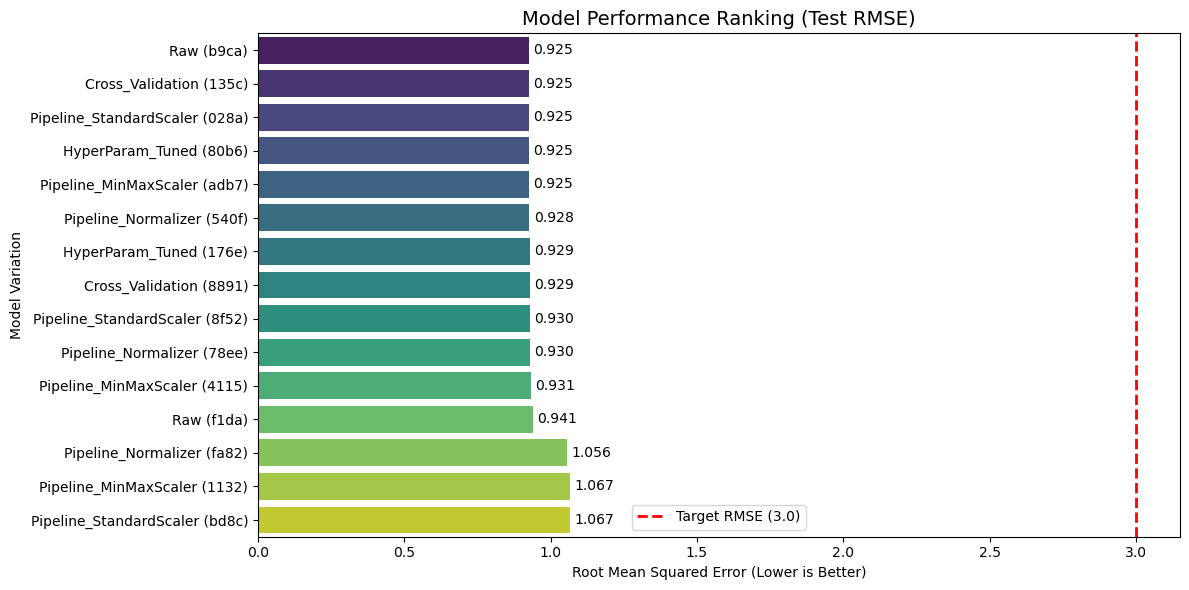

In [14]:
plt.figure(figsize=(12, 6))

# Create Bar Plot
ax = sns.barplot(
    data=df_viz, 
    x="metrics.test_rmse", 
    y="Model_ID", 
    hue="Model_ID", 
    palette="viridis", 
    legend=False
)

# Add Threshold Line (RMSE = 3)
plt.axvline(x=3, color='r', linestyle='--', linewidth=2, label="Target RMSE (3.0)")

# Add Title and Labels
plt.title("Model Performance Ranking (Test RMSE)", fontsize=14)
plt.xlabel("Root Mean Squared Error (Lower is Better)")
plt.ylabel("Model Variation")
plt.legend()

# Display values on bars
for i in ax.containers:
    ax.bar_label(i, fmt="%.3f", padding=3)

plt.tight_layout()
plt.show()

🏆 Best Model: Cross_Validation (135c) | RMSE: 0.9252


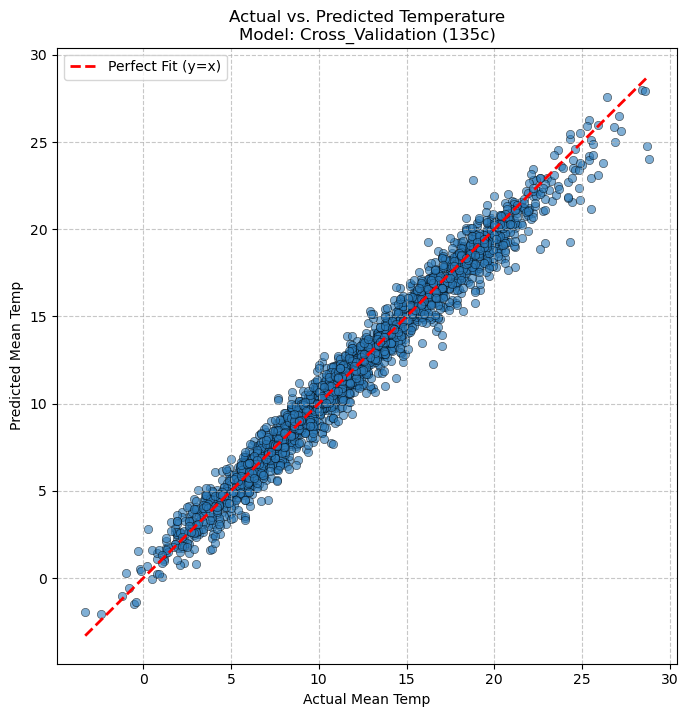

In [18]:
# 1. Identify the Best Run
best_run = df_viz.iloc[1] # First row is best (sorted by RMSE ascending)
best_run_id = best_run.run_id
best_model_name = best_run["Model_ID"]

print(f"🏆 Best Model: {best_model_name} | RMSE: {best_run['metrics.test_rmse']:.4f}")

# 2. Load the Best Model from MLflow
best_model = mlflow.sklearn.load_model(f"runs:/{best_run_id}/model")

# 3. Generate Predictions (Ensure X_test/y_test are currently in memory)
predictions = best_model.predict(X_test)

# 4. Plot Actual vs Predicted
plt.figure(figsize=(8, 8))
sns.scatterplot(x=y_test, y=predictions, alpha=0.6, color="#2b7bba", edgecolor="k")

# Add "Perfect Fit" Line (y=x)
min_val = min(y_test.min(), predictions.min())
max_val = max(y_test.max(), predictions.max())
plt.plot([min_val, max_val], [min_val, max_val], "r--", lw=2, label="Perfect Fit (y=x)")

plt.title(f"Actual vs. Predicted Temperature\nModel: {best_model_name}")
plt.xlabel("Actual Mean Temp")
plt.ylabel("Predicted Mean Temp")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.7)
plt.show()